## Week 10_Wed - LINEAR DATA FITTING WITH UNCERTANTIES

In [1]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [2]:
#Read in the data to a numpy array
data = np.genfromtxt("data\HW10_2data.dat", names=True, dtype=None)  ## creates an array, top line is the name of each column (header)

# print out all columns we just got for free
data.dtype

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

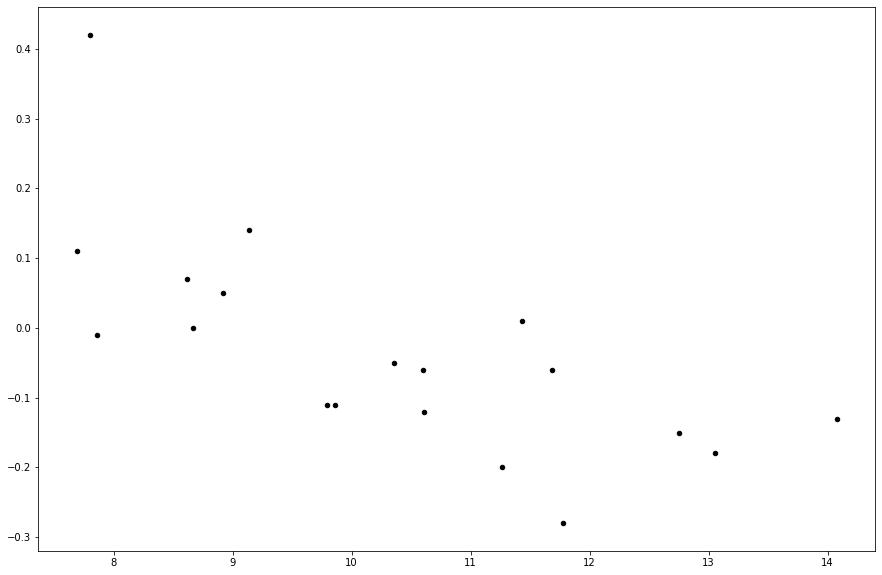

In [3]:
#First let's see what this data looks like
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')

# Cool! The data actually looks pretty linear so we can assume the function we are fitting *is* linear

In [4]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  -0.05818663749944188 0.5653511377902967
raw:  [ 0.00020654 -0.00213008] [-0.00213008  0.02264763]


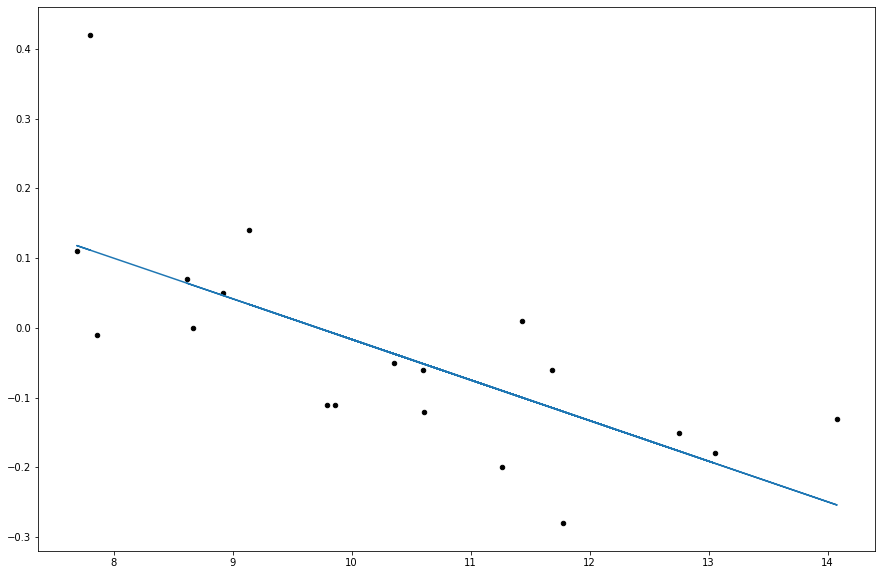

In [5]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


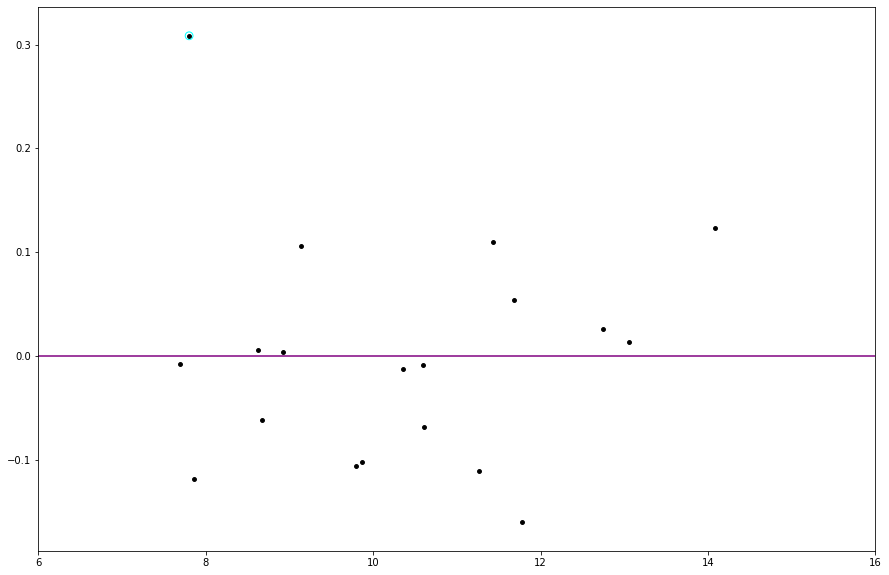

In [6]:
#Let's look into wich data are way off the fit. The residuals.

residual = data['Y']-linear(data['X'],*popt)  ## how far off in y is each data point from our fit.
x = np.linspace(5,20,1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(6,16)

outlier = np.absolute(residual)>0.2  ## if residual > 0.2, we change the color to mark it as an outlier.
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')

# perfect fit would be zero. 

raw:  -0.05818663749944188 0.5653511377902967
outliers accounted for:  -0.04338146805673531 0.3967292540601484


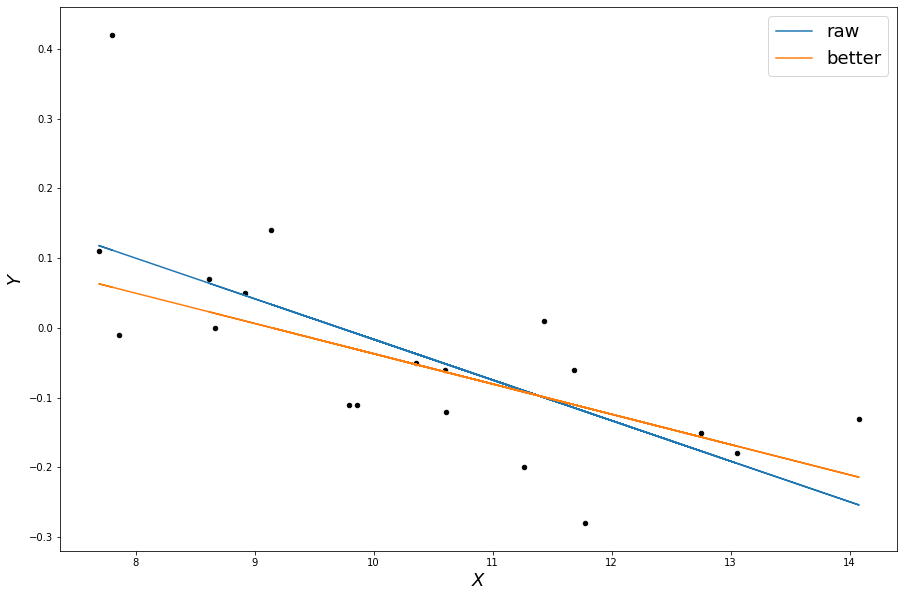

In [7]:
# our values for the raw data above:
# slope:    -0.058187
# intercept: 0.565351
popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically. Take away the outliers. 

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Y'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
#ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
#            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.038335615619586275 0.3463734445963487


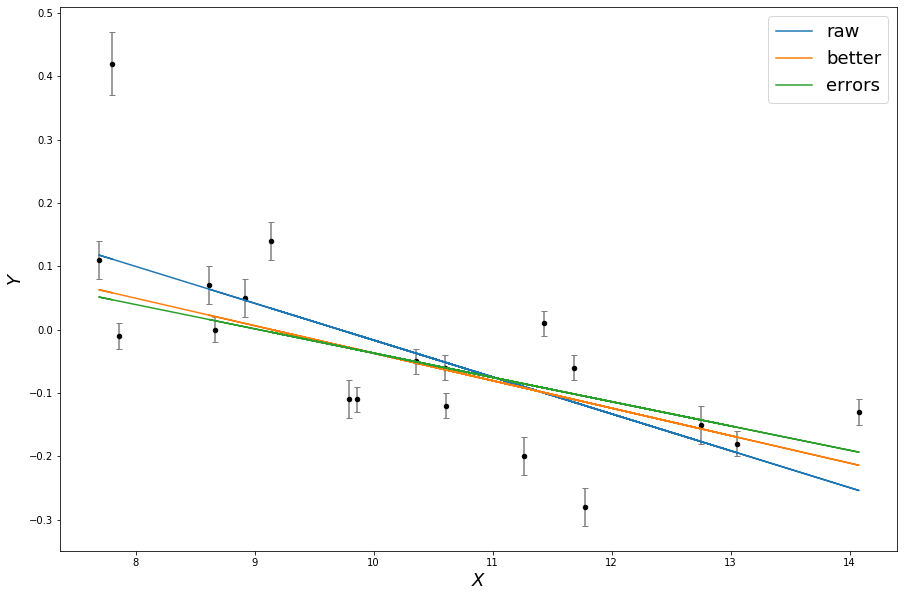

In [8]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: -0.0581, mean intercept: 0.5640


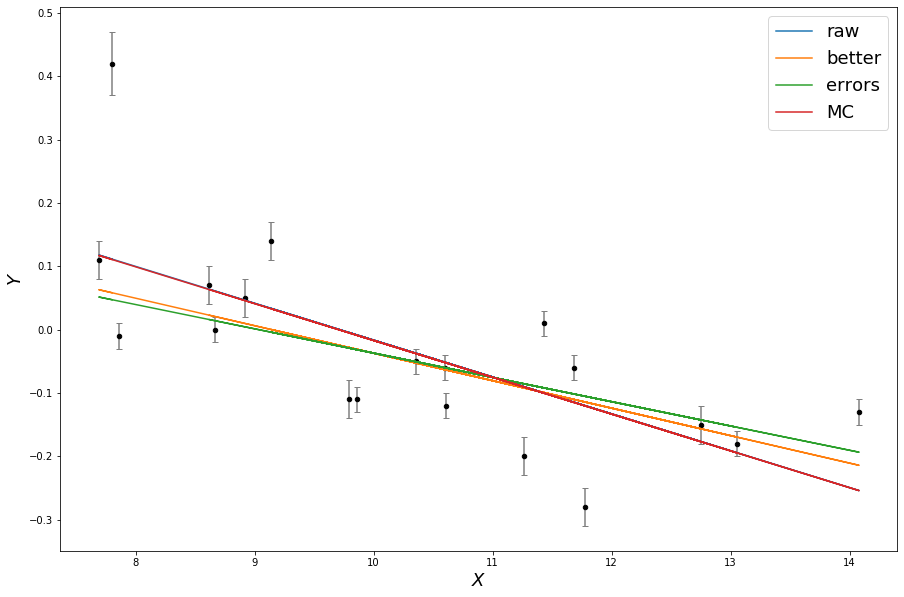

In [9]:
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [23]:
# oh right, that outlier.

mask = data['Y'] < 0.3

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  18


TypeError: mcFit() missing 1 required positional argument: 'y_err'

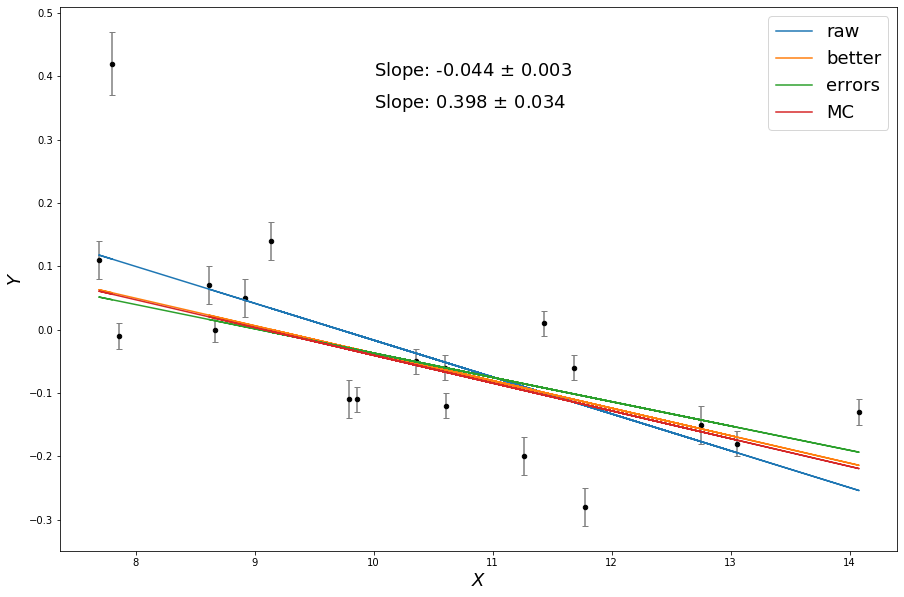

In [11]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

0.39823208271684074


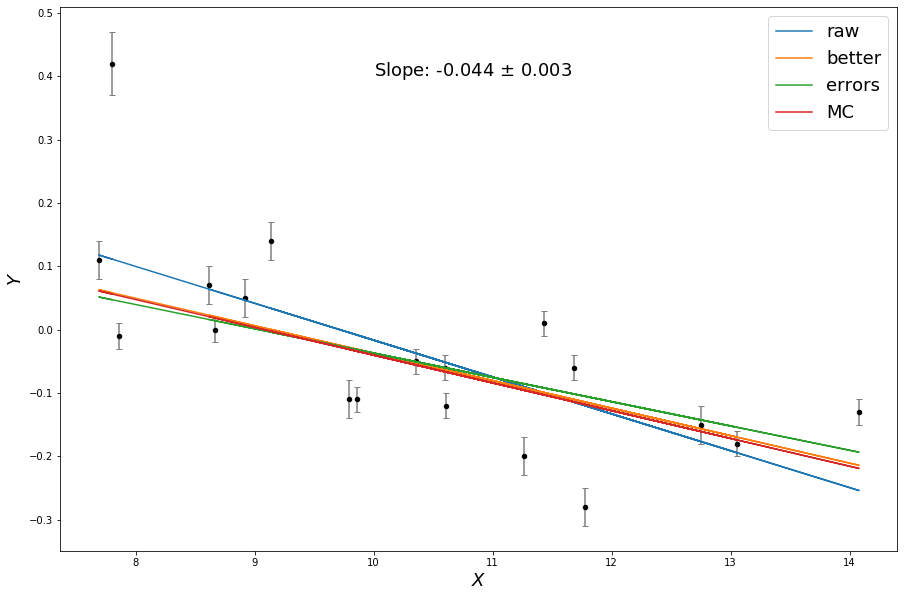

In [12]:
# here's an example of the use of lampda functions: simplifying or modifying another function
params, other = opt.curve_fit(lambda x, b: linear(x, np.mean(slope), b), xdat, ydat)

fixed_int = params[0]

print(fixed_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), fixed_int), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
# ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [ ]:
# exercise: we can't know the x data perfectly
# suppose the data have uniform x errors of 0.5. Sigma
# use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors

# repeat this exercise, but supposing the errors INCREASE as we move away from X = 8 (as they do)
# to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit . Sigma 

# plot both slopes. how does the fit change? 

In [ ]:
# Repeat the above anaysis for X vs. Z data, including uncertainties!!

1. X_ERR = 0.5

mean slope: -0.0408, mean intercept: 0.3663
uncertainty for slope is +/-  0.005063140799263776
uncertainty for intercepts is +/-  0.053467226027862545


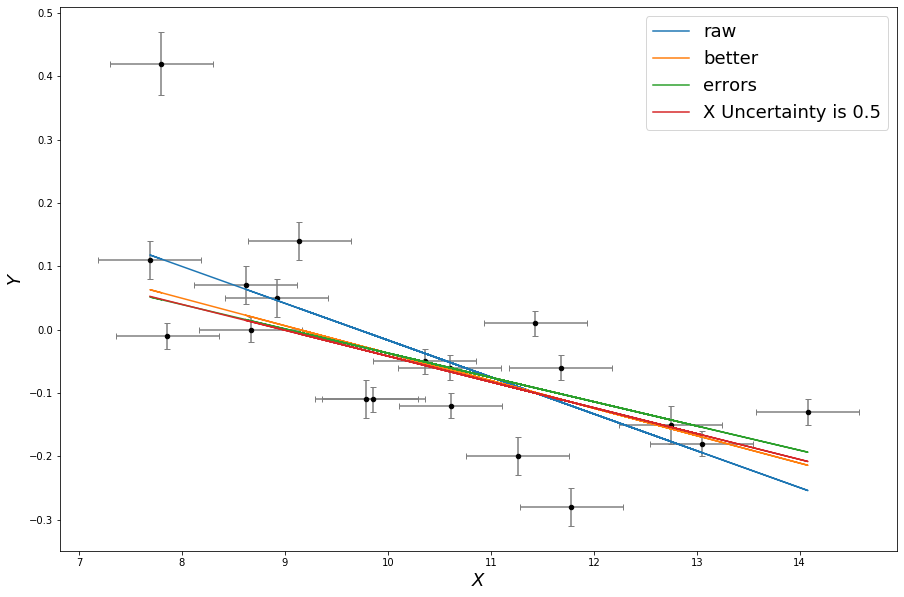

In [30]:
mask = data['Y'] < 0.3

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]


# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, x_err, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_y = np.random.randn(len(y))
        weights_x = np.random.randn(len(x))
        
        x_err = 0.5

        y_adj = y + y_err*weights_y
        x_adj = x + x_err*weights_x

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(xdat, xdat*0+0.5, ydat, ydat_err)

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))
uncertainty_slope = np.std(slope)   ## standard deviation of the slopes
uncertainty_int = np.std(intercept)
print('uncertainty for slope is +/- ', uncertainty_slope)
print('uncertainty for intercepts is +/- ', uncertainty_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], xerr=data['X']*0+0.5, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
# ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='With X Errors')
ax.plot(xdat, linear(xdat, np.mean(slope), np.mean(intercept)), label='X Uncertainty is 0.5')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

2. Now X_ERR = |x-8|/10

mean slope: -0.0425, mean intercept: 0.3851
uncertainty for slope is +/-  0.0045953119122344385
uncertainty for intercepts is +/-  0.04752523500051654


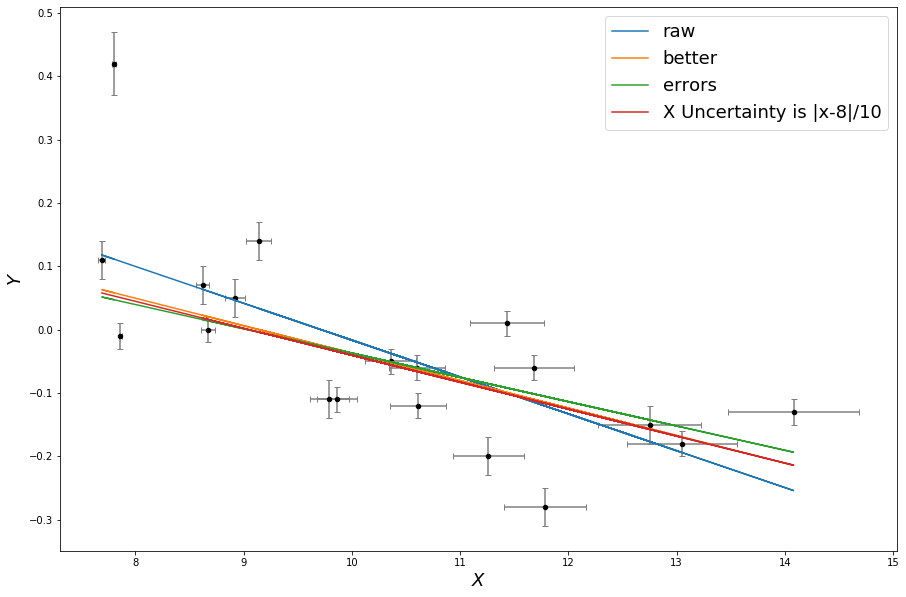

In [31]:
mask = data['Y'] < 0.3

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]


# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, x_err, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_y = np.random.randn(len(y))
        weights_x = np.random.randn(len(x))
        
        x_err = np.abs(x-8)/10

        y_adj = y + y_err*weights_y
        x_adj = x + x_err*weights_x

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(xdat, xdat*0+0.5, ydat, ydat_err)

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))
uncertainty_slope = np.std(slope)   ## standard deviation of the slopes
uncertainty_int = np.std(intercept)
print('uncertainty for slope is +/- ', uncertainty_slope)
print('uncertainty for intercepts is +/- ', uncertainty_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], xerr=np.abs(data['X']-8)/10, c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
# ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='With X Errors')
ax.plot(xdat, linear(xdat, np.mean(slope), np.mean(intercept)), label='X Uncertainty is |x-8|/10')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

The slope becomes slightly more negative when the x uncertainty is no longer just 0.5, it changed from -0.0408 to -0.0425. The fit then becomes more in-between the "better" and "errors" fits, almost "splitting the difference." 

3. 

First we'll plot the X v. Z data just to get a sense of the data and see if there are any outliers.

raw:  13.088388854673305 10.306269268251743
raw:  [ 1.04532063e+02 -5.50168022e-02] [-0.0550168   0.17660416]


Text(0, 0.5, '$X$')

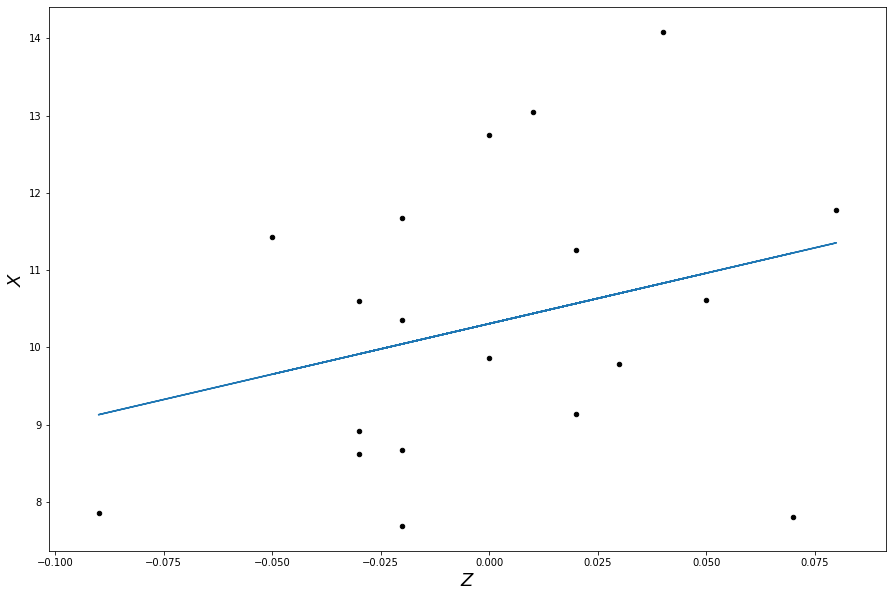

In [59]:
# The points plotted
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['Z'],data['X'],s=20,c='black')

# The best fit (linear)
def linear(z, m, b):
    return m * z + b
popt, pcov = opt.curve_fit(linear, data['Z'], data['X'])
print("raw: ", *popt)
print("raw: ", *pcov)
ax.plot(data['Z'],linear(data['Z'], *popt))

# Labels 
ax.set_xlabel('$Z$', fontsize=18)
ax.set_ylabel('$X$', fontsize=18)

Check to see which (if any) of these points will be considered outliers to us.

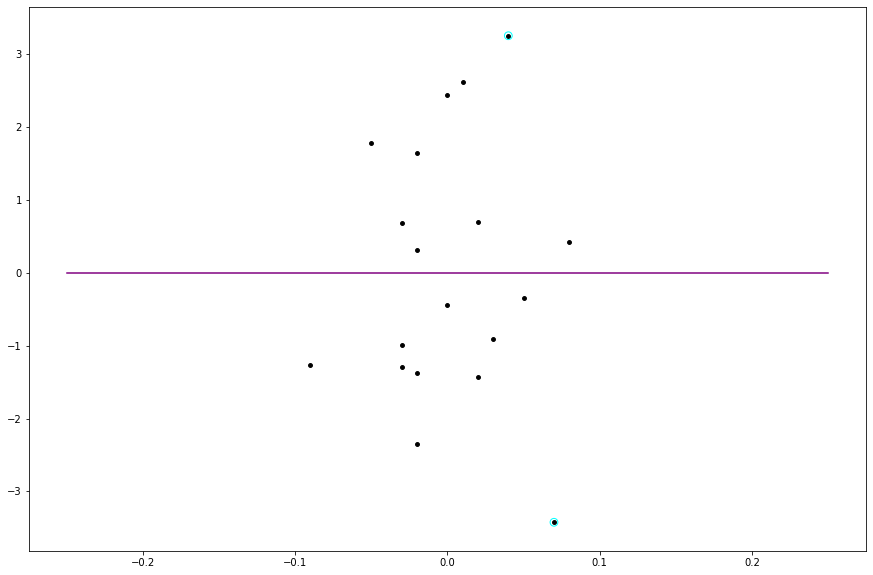

In [61]:
#Let's look into wich data are way off the fit. The residuals.

residual = data['X']-linear(data['Z'],*popt)  ## how far off in y is each data point from our fit.
x = np.linspace(-0.25,0.25,1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['Z'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
#ax.set_xlim(-0.2,0.2)
#ax.set_ylim(6,15)

outlier = np.absolute(residual)>3  ## if residual > 3, we change the color to mark it as an outlier.
ax.scatter(data['Z'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')

# perfect fit would be zero.

Now we can go from here as we did before to make our fits, making sure we axclude the highlighted outliers in our fits.

X uncertainty is just 0.5

mean slope: 3.7463, mean intercept: 10.0758
uncertainty for slope is +/-  5.922932010406387
uncertainty for intercepts is +/-  0.14884716160848757


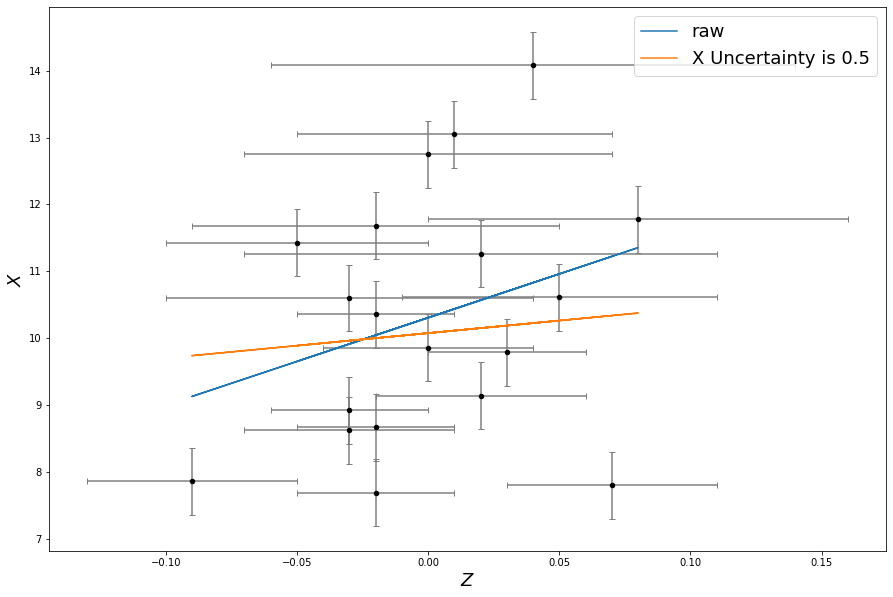

In [69]:
mask = np.abs(residual < 3) 

xdat = data['X'][mask]
zdat = data['Z'][mask]
zdat_err = data['Z_ERR'][mask]


# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, x_err, z, z_err):
    slopes = list()
    z_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_z = np.random.randn(len(z))
        weights_x = np.random.randn(len(x))
        
        x_err = 0.5

        z_adj = z + z_err*weights_z
        x_adj = x + x_err*weights_x

        params, other = opt.curve_fit(linear, z_adj, x_adj)
        slopes.append(params[0])
        z_ints.append(params[1])
    
    return slopes, z_ints

slope, intercept = mcFit(xdat, xdat*0+0.5, zdat, zdat_err)

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))
uncertainty_slope = np.std(slope)   ## standard deviation of the slopes
uncertainty_int = np.std(intercept)
print('uncertainty for slope is +/- ', uncertainty_slope)
print('uncertainty for intercepts is +/- ', uncertainty_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['Z'], data['X'],s=20,c='black',zorder=2)
ax.errorbar(data['Z'], data['X'],yerr=data['X']*0+0.5, xerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['Z'], linear(data['Z'], *popt), label='raw')
#ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
#ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
# ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='With X Errors')
ax.plot(zdat, linear(zdat, np.mean(slope), np.mean(intercept)), label='X Uncertainty is 0.5')

ax.set_xlabel('$Z$', fontsize=18)
ax.set_ylabel('$X$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

4. Now with X uncertainty of |x-8|/10

mean slope: 2.9818, mean intercept: 10.0881
uncertainty for slope is +/-  5.266176723662769
uncertainty for intercepts is +/-  0.10133858289594802


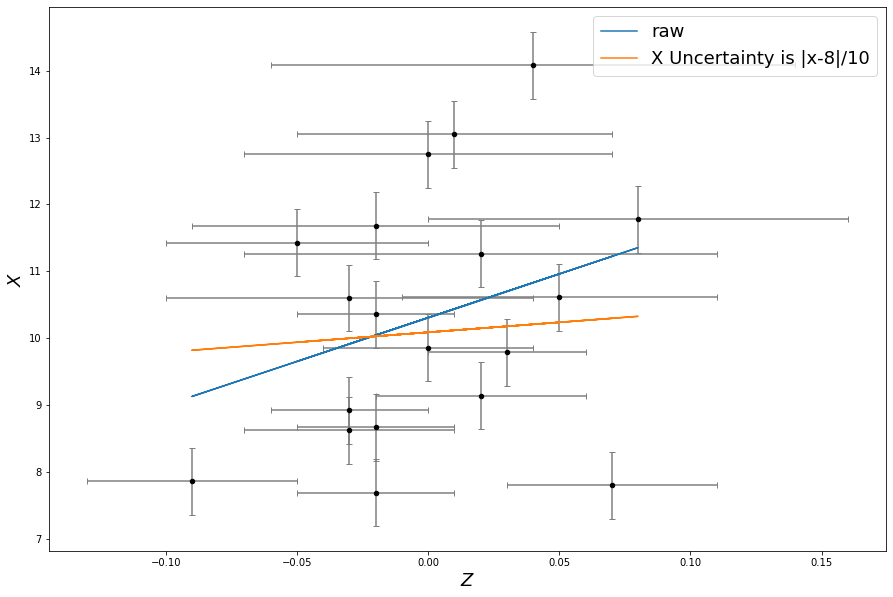

In [71]:
mask = np.abs(residual < 3) 

xdat = data['X'][mask]
zdat = data['Z'][mask]
zdat_err = data['Z_ERR'][mask]


# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, x_err, z, z_err):
    slopes = list()
    z_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights_z = np.random.randn(len(z))
        weights_x = np.random.randn(len(x))
        
        x_err = np.abs(x-8)/10

        z_adj = z + z_err*weights_z
        x_adj = x + x_err*weights_x

        params, other = opt.curve_fit(linear, z_adj, x_adj)
        slopes.append(params[0])
        z_ints.append(params[1])
    
    return slopes, z_ints

slope, intercept = mcFit(xdat, xdat*0+0.5, zdat, zdat_err)

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))
uncertainty_slope = np.std(slope)   ## standard deviation of the slopes
uncertainty_int = np.std(intercept)
print('uncertainty for slope is +/- ', uncertainty_slope)
print('uncertainty for intercepts is +/- ', uncertainty_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['Z'], data['X'],s=20,c='black',zorder=2)
ax.errorbar(data['Z'], data['X'],yerr=data['X']*0+0.5, xerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['Z'], linear(data['Z'], *popt), label='raw')
#ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
#ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
# ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='With X Errors')
ax.plot(zdat, linear(zdat, np.mean(slope), np.mean(intercept)), label='X Uncertainty is |x-8|/10')

ax.set_xlabel('$Z$', fontsize=18)
ax.set_ylabel('$X$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

The slope increased slightly from 10.0758 to 10.0881 and the intercept decreased, going from 3.7463 to 2.9818. Our fit is always going to be better when we exclude outliers, which is why both graphs are different from the "raw" data lines. Given the nature of the data it's hard to say whether the fits are that great because the data points don't show too much of a trend, however, the fit is ok for our current purposes. The largest difference between the two is that the uncertainty in slope and intercept actually decreased by a decent amount when the x uncertainty became |x-8|/10 as opposed to just x=0.5. This may be due to the fact that most of the x values will have an uncertainty less than just 0.5, except for x values greater than or equal to 13, which is only a few points. 